In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

144

***
## model training: evaluation

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.7999999999999999,
    'drop_rate': 0.01,
    'feature_fraction': 0.30000000000000004,
    'lambda_l1': 0.0030962221232624376,
    'lambda_l2': 3.715581074744768,
    'max_drop': 50,
    'min_data_in_leaf': 1000,
    'num_iterations': 1800,
    'path_smooth': 9.114173802307661,
    'skip_drop': 0.4,
    'num_leaves': 128
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.896681	valid_0's pearsonr: 0.129163


[100]	valid_0's rmse: 0.896075	valid_0's pearsonr: 0.131342


[150]	valid_0's rmse: 0.895626	valid_0's pearsonr: 0.133491


[200]	valid_0's rmse: 0.895412	valid_0's pearsonr: 0.135219


[250]	valid_0's rmse: 0.895088	valid_0's pearsonr: 0.137018


[300]	valid_0's rmse: 0.894859	valid_0's pearsonr: 0.13822


[350]	valid_0's rmse: 0.894863	valid_0's pearsonr: 0.138441


[400]	valid_0's rmse: 0.894553	valid_0's pearsonr: 0.140675


[450]	valid_0's rmse: 0.89444	valid_0's pearsonr: 0.141265


[500]	valid_0's rmse: 0.894382	valid_0's pearsonr: 0.141462


[550]	valid_0's rmse: 0.894343	valid_0's pearsonr: 0.141513


[600]	valid_0's rmse: 0.89426	valid_0's pearsonr: 0.142057


[650]	valid_0's rmse: 0.894221	valid_0's pearsonr: 0.14276


[700]	valid_0's rmse: 0.894173	valid_0's pearsonr: 0.142865


[750]	valid_0's rmse: 0.894176	valid_0's pearsonr: 0.142973


[800]	valid_0's rmse: 0.894036	valid_0's pearsonr: 0.143912


[850]	valid_0's rmse: 0.894013	valid_0's pearsonr: 0.143617


[900]	valid_0's rmse: 0.893945	valid_0's pearsonr: 0.143967


[950]	valid_0's rmse: 0.893957	valid_0's pearsonr: 0.143812


[1000]	valid_0's rmse: 0.893959	valid_0's pearsonr: 0.14363


[1050]	valid_0's rmse: 0.893929	valid_0's pearsonr: 0.143826


[1100]	valid_0's rmse: 0.893951	valid_0's pearsonr: 0.143544


[1150]	valid_0's rmse: 0.893958	valid_0's pearsonr: 0.14335


[1200]	valid_0's rmse: 0.893862	valid_0's pearsonr: 0.144141


[1250]	valid_0's rmse: 0.893805	valid_0's pearsonr: 0.144543


[1300]	valid_0's rmse: 0.89372	valid_0's pearsonr: 0.14514


[1350]	valid_0's rmse: 0.893761	valid_0's pearsonr: 0.14465


[1400]	valid_0's rmse: 0.893679	valid_0's pearsonr: 0.145285


[1450]	valid_0's rmse: 0.893665	valid_0's pearsonr: 0.145423


[1500]	valid_0's rmse: 0.893622	valid_0's pearsonr: 0.145789


[1550]	valid_0's rmse: 0.89366	valid_0's pearsonr: 0.145488


[1600]	valid_0's rmse: 0.893636	valid_0's pearsonr: 0.145611


[1650]	valid_0's rmse: 0.89363	valid_0's pearsonr: 0.145663


[1700]	valid_0's rmse: 0.893623	valid_0's pearsonr: 0.145711


[1750]	valid_0's rmse: 0.893633	valid_0's pearsonr: 0.145614


[1800]	valid_0's rmse: 0.89363	valid_0's pearsonr: 0.145628


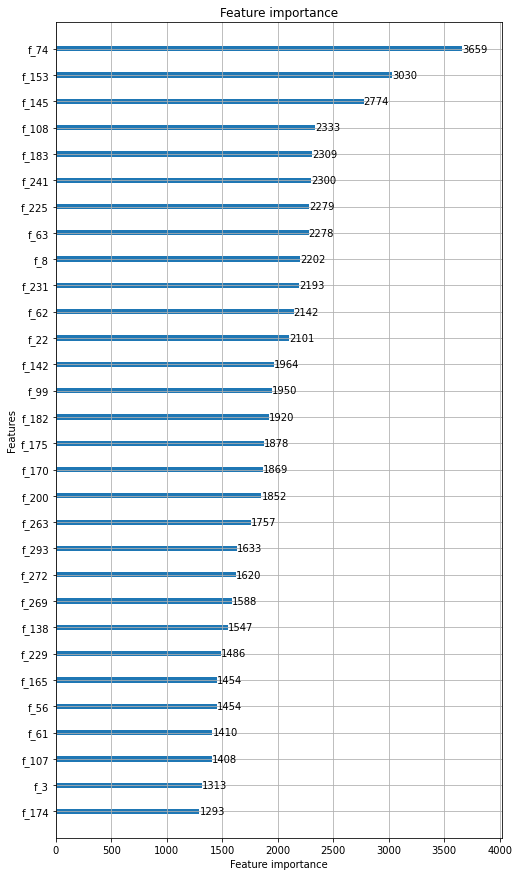

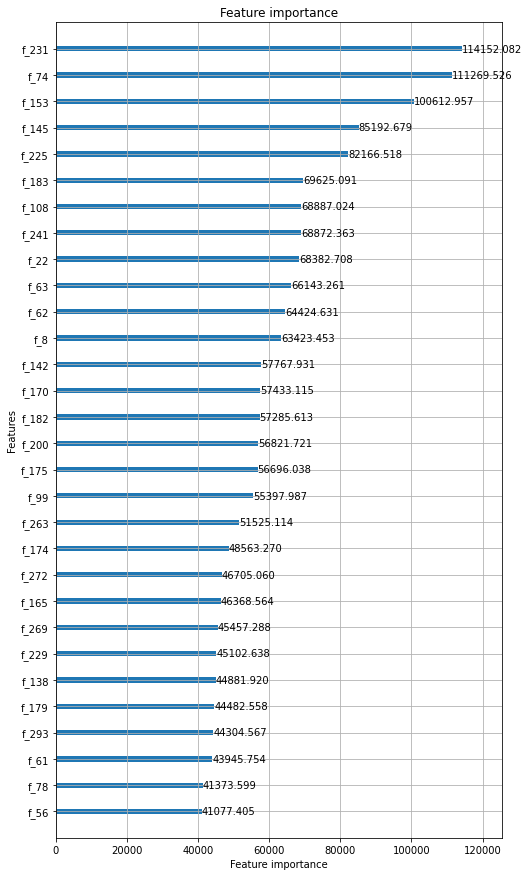

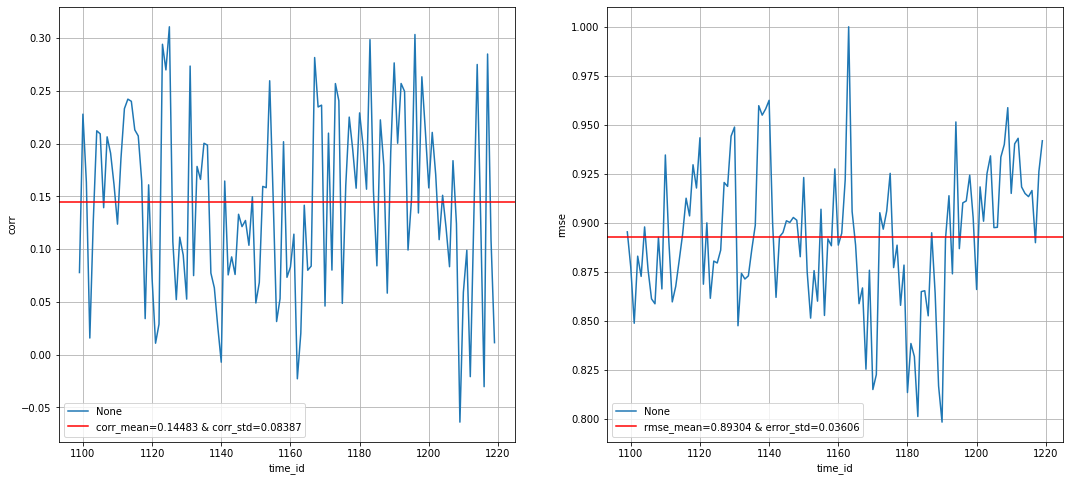

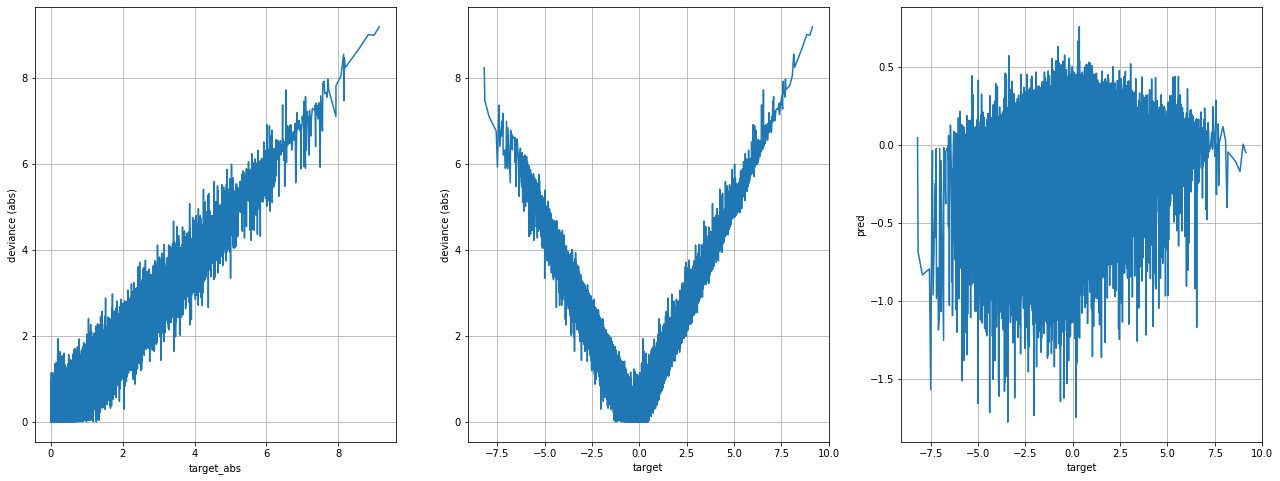

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.904093	valid_0's pearsonr: 0.124173


[100]	valid_0's rmse: 0.903104	valid_0's pearsonr: 0.131177


[150]	valid_0's rmse: 0.90251	valid_0's pearsonr: 0.134675


[200]	valid_0's rmse: 0.902285	valid_0's pearsonr: 0.136547


[250]	valid_0's rmse: 0.902026	valid_0's pearsonr: 0.137708


[300]	valid_0's rmse: 0.901817	valid_0's pearsonr: 0.138643


[350]	valid_0's rmse: 0.901723	valid_0's pearsonr: 0.139743


[400]	valid_0's rmse: 0.901534	valid_0's pearsonr: 0.140827


[450]	valid_0's rmse: 0.901466	valid_0's pearsonr: 0.140913


[500]	valid_0's rmse: 0.901439	valid_0's pearsonr: 0.140703


[550]	valid_0's rmse: 0.901312	valid_0's pearsonr: 0.141342


[600]	valid_0's rmse: 0.901198	valid_0's pearsonr: 0.142123


[650]	valid_0's rmse: 0.901219	valid_0's pearsonr: 0.142367


[700]	valid_0's rmse: 0.901128	valid_0's pearsonr: 0.142654


[750]	valid_0's rmse: 0.901152	valid_0's pearsonr: 0.142656


[800]	valid_0's rmse: 0.901095	valid_0's pearsonr: 0.142886


[850]	valid_0's rmse: 0.900995	valid_0's pearsonr: 0.143157


[900]	valid_0's rmse: 0.900923	valid_0's pearsonr: 0.143545


[950]	valid_0's rmse: 0.90091	valid_0's pearsonr: 0.143524


[1000]	valid_0's rmse: 0.900912	valid_0's pearsonr: 0.143265


[1050]	valid_0's rmse: 0.900906	valid_0's pearsonr: 0.14325


[1100]	valid_0's rmse: 0.900887	valid_0's pearsonr: 0.143228


[1150]	valid_0's rmse: 0.900826	valid_0's pearsonr: 0.143506


[1200]	valid_0's rmse: 0.900839	valid_0's pearsonr: 0.143388


[1250]	valid_0's rmse: 0.900828	valid_0's pearsonr: 0.143436


[1300]	valid_0's rmse: 0.90077	valid_0's pearsonr: 0.143825


[1350]	valid_0's rmse: 0.90083	valid_0's pearsonr: 0.143125


[1400]	valid_0's rmse: 0.90081	valid_0's pearsonr: 0.14326


[1450]	valid_0's rmse: 0.900781	valid_0's pearsonr: 0.143513


[1500]	valid_0's rmse: 0.900797	valid_0's pearsonr: 0.143429


[1550]	valid_0's rmse: 0.900773	valid_0's pearsonr: 0.14361


[1600]	valid_0's rmse: 0.900739	valid_0's pearsonr: 0.143827


[1650]	valid_0's rmse: 0.900782	valid_0's pearsonr: 0.143495


[1700]	valid_0's rmse: 0.900746	valid_0's pearsonr: 0.143774


[1750]	valid_0's rmse: 0.900707	valid_0's pearsonr: 0.144059


[1800]	valid_0's rmse: 0.900647	valid_0's pearsonr: 0.144505


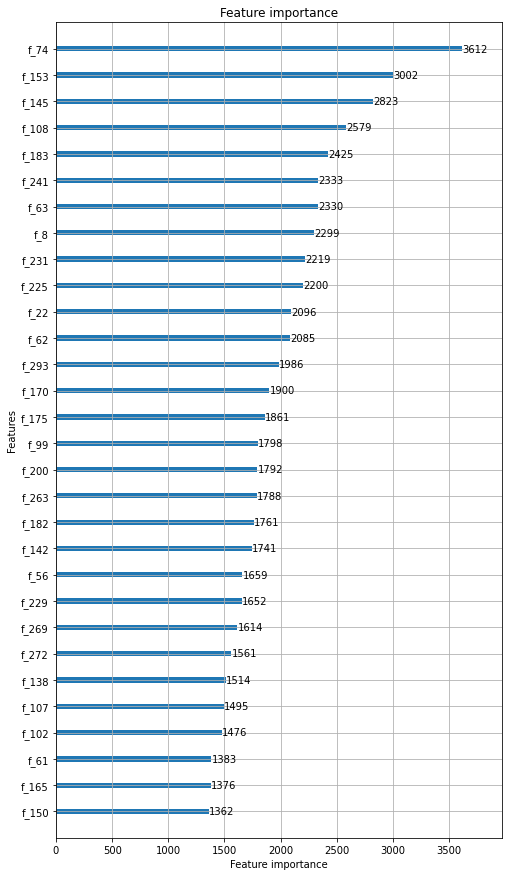

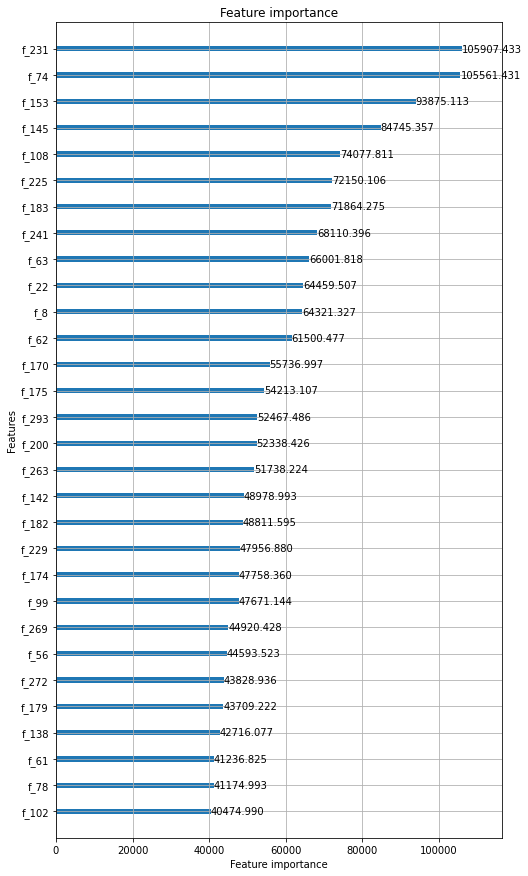

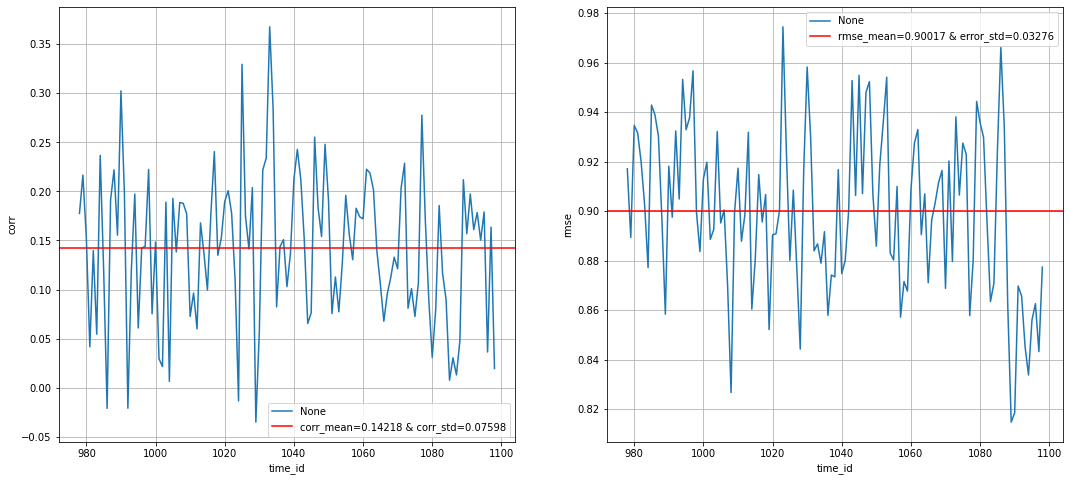

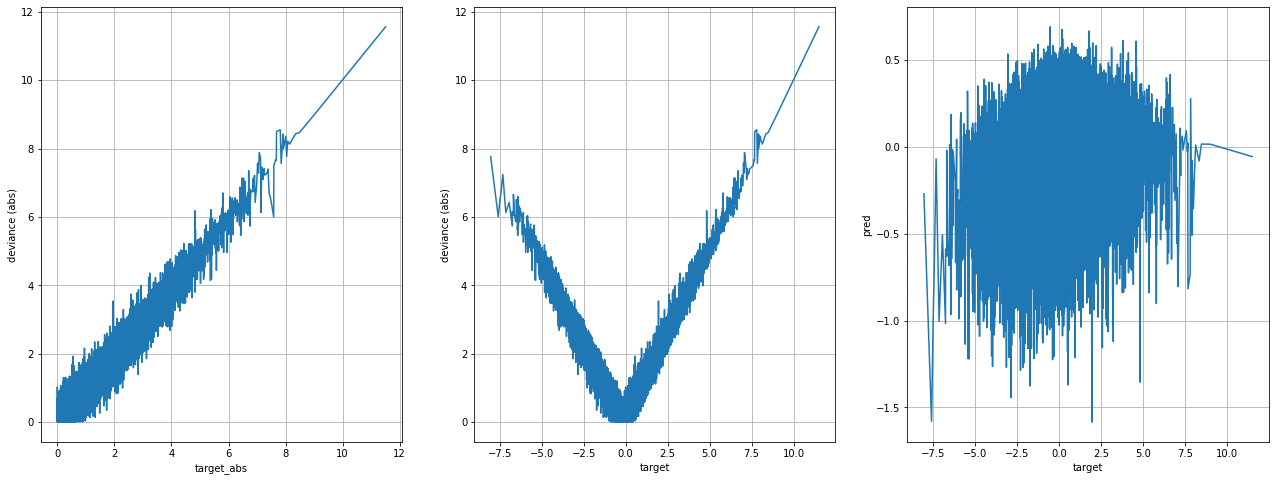

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.938709	valid_0's pearsonr: 0.108264


[100]	valid_0's rmse: 0.937758	valid_0's pearsonr: 0.116291


[150]	valid_0's rmse: 0.937123	valid_0's pearsonr: 0.121241


[200]	valid_0's rmse: 0.936745	valid_0's pearsonr: 0.124957


[250]	valid_0's rmse: 0.936422	valid_0's pearsonr: 0.127268


[300]	valid_0's rmse: 0.936221	valid_0's pearsonr: 0.128404


[350]	valid_0's rmse: 0.936088	valid_0's pearsonr: 0.129838


[400]	valid_0's rmse: 0.935881	valid_0's pearsonr: 0.131289


[450]	valid_0's rmse: 0.935678	valid_0's pearsonr: 0.132765


[500]	valid_0's rmse: 0.935553	valid_0's pearsonr: 0.133551


[550]	valid_0's rmse: 0.935399	valid_0's pearsonr: 0.134546


[600]	valid_0's rmse: 0.935315	valid_0's pearsonr: 0.135101


[650]	valid_0's rmse: 0.935306	valid_0's pearsonr: 0.135468


[700]	valid_0's rmse: 0.935211	valid_0's pearsonr: 0.135974


[750]	valid_0's rmse: 0.935112	valid_0's pearsonr: 0.137087


[800]	valid_0's rmse: 0.935075	valid_0's pearsonr: 0.137184


[850]	valid_0's rmse: 0.934929	valid_0's pearsonr: 0.137983


[900]	valid_0's rmse: 0.934791	valid_0's pearsonr: 0.138876


[950]	valid_0's rmse: 0.93473	valid_0's pearsonr: 0.139275


[1000]	valid_0's rmse: 0.934651	valid_0's pearsonr: 0.139726


[1050]	valid_0's rmse: 0.934566	valid_0's pearsonr: 0.140403


[1100]	valid_0's rmse: 0.934527	valid_0's pearsonr: 0.140576


[1150]	valid_0's rmse: 0.934442	valid_0's pearsonr: 0.141076


[1200]	valid_0's rmse: 0.934441	valid_0's pearsonr: 0.141105


[1250]	valid_0's rmse: 0.934367	valid_0's pearsonr: 0.141679


[1300]	valid_0's rmse: 0.934304	valid_0's pearsonr: 0.142135


[1350]	valid_0's rmse: 0.934201	valid_0's pearsonr: 0.142705


[1400]	valid_0's rmse: 0.934171	valid_0's pearsonr: 0.142912


[1450]	valid_0's rmse: 0.934144	valid_0's pearsonr: 0.143127


[1500]	valid_0's rmse: 0.934158	valid_0's pearsonr: 0.143063


[1550]	valid_0's rmse: 0.93404	valid_0's pearsonr: 0.143994


[1600]	valid_0's rmse: 0.933989	valid_0's pearsonr: 0.144297


[1650]	valid_0's rmse: 0.934005	valid_0's pearsonr: 0.144156


[1700]	valid_0's rmse: 0.934032	valid_0's pearsonr: 0.143937


[1750]	valid_0's rmse: 0.934088	valid_0's pearsonr: 0.143508


[1800]	valid_0's rmse: 0.934083	valid_0's pearsonr: 0.143532


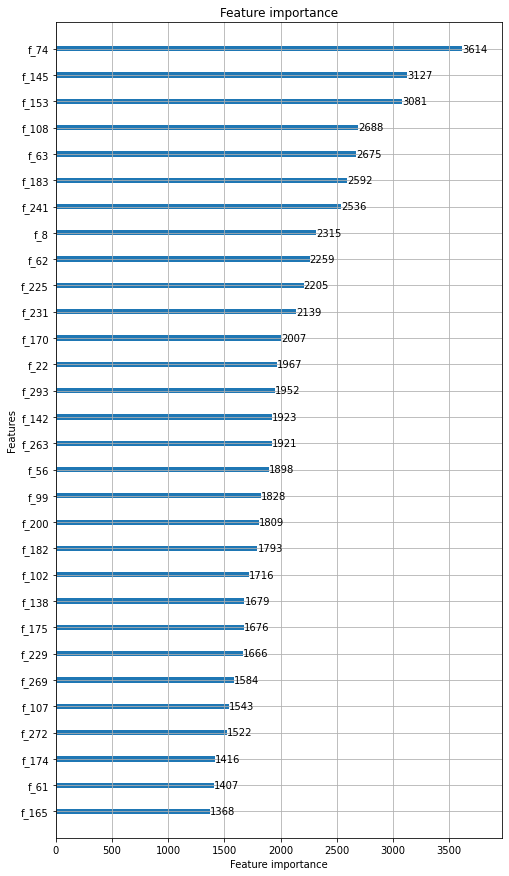

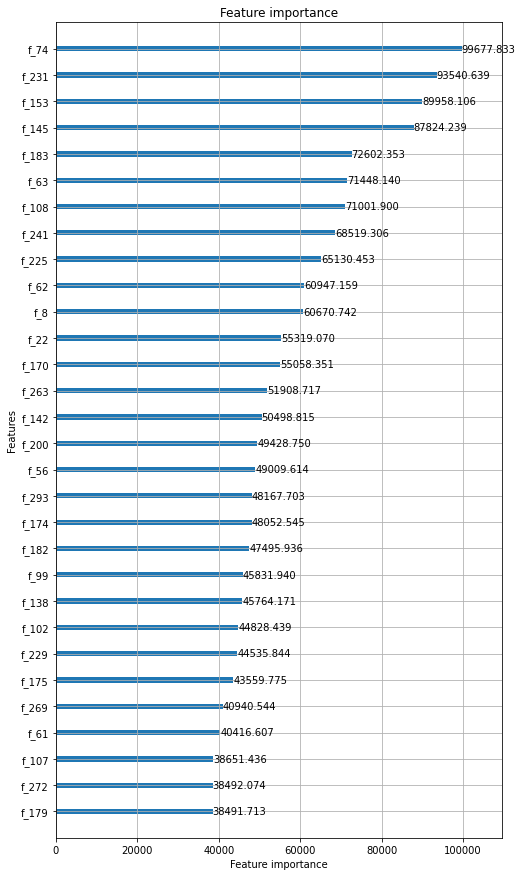

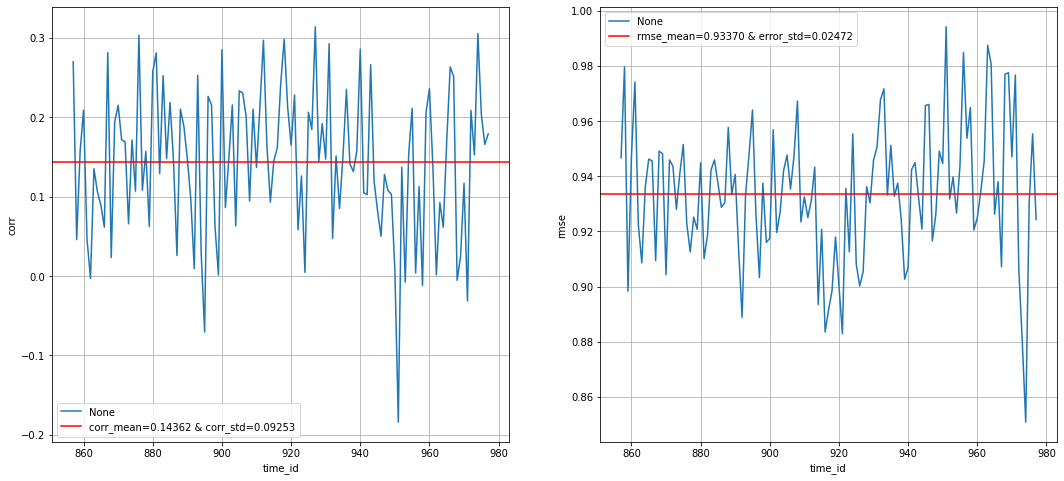

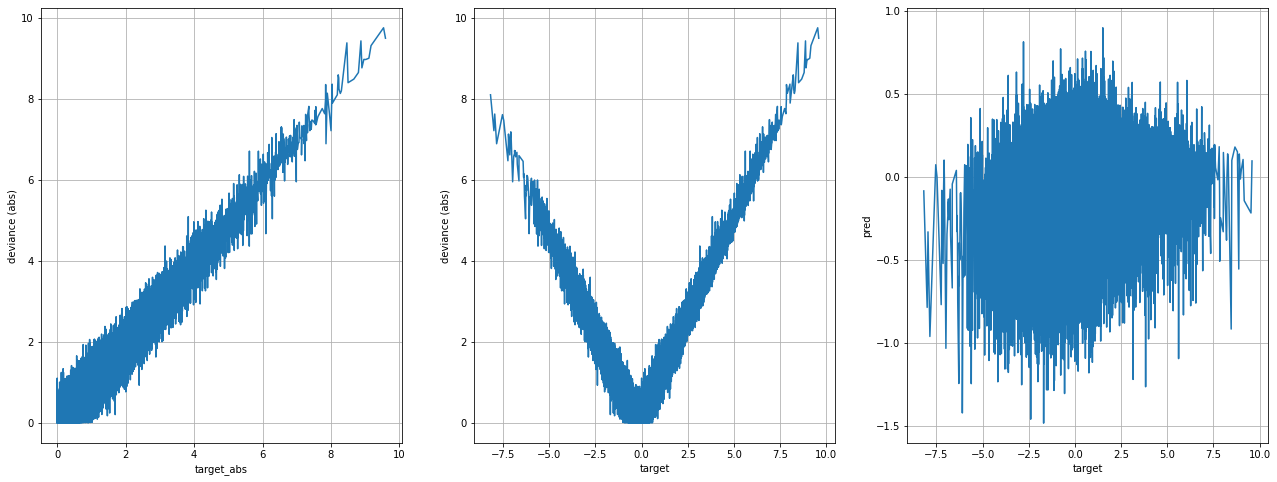

In [10]:
evaluate = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if evaluate:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        log_callback = lgb.log_evaluation(period=50,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()


In [11]:
metrics

{'corr_mean': [0.14482666473629902, 0.14218080594491195, 0.14361981649337824],
 'corr_std': [0.08386960619070627, 0.07597557302225476, 0.0925259553080694],
 'error_mean': [0.893040962240241, 0.9001673022315124, 0.9336951383346629],
 'error_std': [0.036060929809351334, 0.0327576913533427, 0.024716553079800446]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.1435424290581964

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9089678009354721

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	training's rmse: 0.909176	training's pearsonr: 0.173481


[100]	training's rmse: 0.905309	training's pearsonr: 0.199508


[150]	training's rmse: 0.902507	training's pearsonr: 0.218535


[200]	training's rmse: 0.900891	training's pearsonr: 0.229927


[250]	training's rmse: 0.899187	training's pearsonr: 0.240101


[300]	training's rmse: 0.897892	training's pearsonr: 0.248386


[350]	training's rmse: 0.896812	training's pearsonr: 0.255177


[400]	training's rmse: 0.896318	training's pearsonr: 0.260289


[450]	training's rmse: 0.895448	training's pearsonr: 0.264839


[500]	training's rmse: 0.894555	training's pearsonr: 0.269428


[550]	training's rmse: 0.893656	training's pearsonr: 0.273426


[600]	training's rmse: 0.893286	training's pearsonr: 0.276403


[650]	training's rmse: 0.892174	training's pearsonr: 0.281011


[700]	training's rmse: 0.891664	training's pearsonr: 0.284747


[750]	training's rmse: 0.890588	training's pearsonr: 0.28904


[800]	training's rmse: 0.890469	training's pearsonr: 0.291101


[850]	training's rmse: 0.889328	training's pearsonr: 0.295294


[900]	training's rmse: 0.888302	training's pearsonr: 0.299809


[950]	training's rmse: 0.887792	training's pearsonr: 0.303238


[1000]	training's rmse: 0.887687	training's pearsonr: 0.305178


[1050]	training's rmse: 0.886809	training's pearsonr: 0.308611


[1100]	training's rmse: 0.885754	training's pearsonr: 0.312579


[1150]	training's rmse: 0.885417	training's pearsonr: 0.314827


[1200]	training's rmse: 0.884815	training's pearsonr: 0.317227


[1250]	training's rmse: 0.884275	training's pearsonr: 0.319937


[1300]	training's rmse: 0.884081	training's pearsonr: 0.321635


[1350]	training's rmse: 0.883885	training's pearsonr: 0.323067


[1400]	training's rmse: 0.883199	training's pearsonr: 0.325569


[1450]	training's rmse: 0.882531	training's pearsonr: 0.328488


[1500]	training's rmse: 0.882286	training's pearsonr: 0.330017


[1550]	training's rmse: 0.881649	training's pearsonr: 0.332515


[1600]	training's rmse: 0.881289	training's pearsonr: 0.33427


[1650]	training's rmse: 0.881024	training's pearsonr: 0.335557


[1700]	training's rmse: 0.880252	training's pearsonr: 0.338014


[1750]	training's rmse: 0.879571	training's pearsonr: 0.340547


[1800]	training's rmse: 0.879489	training's pearsonr: 0.342089


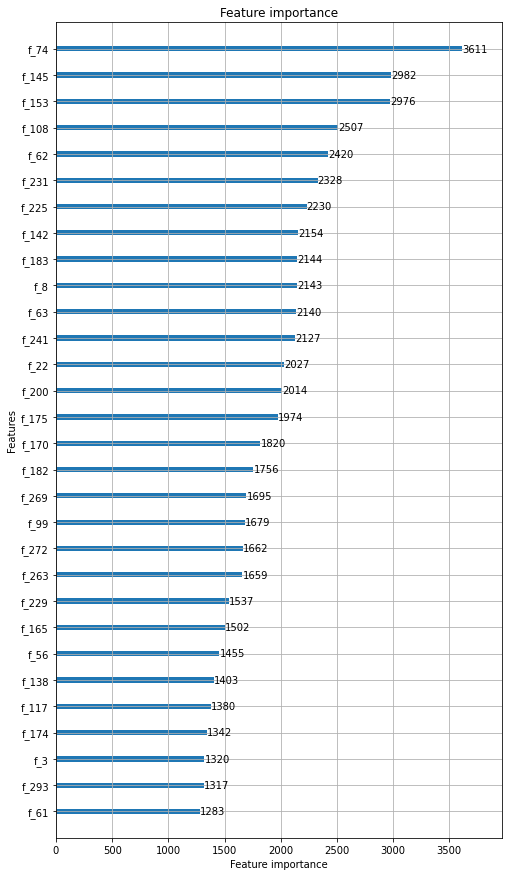

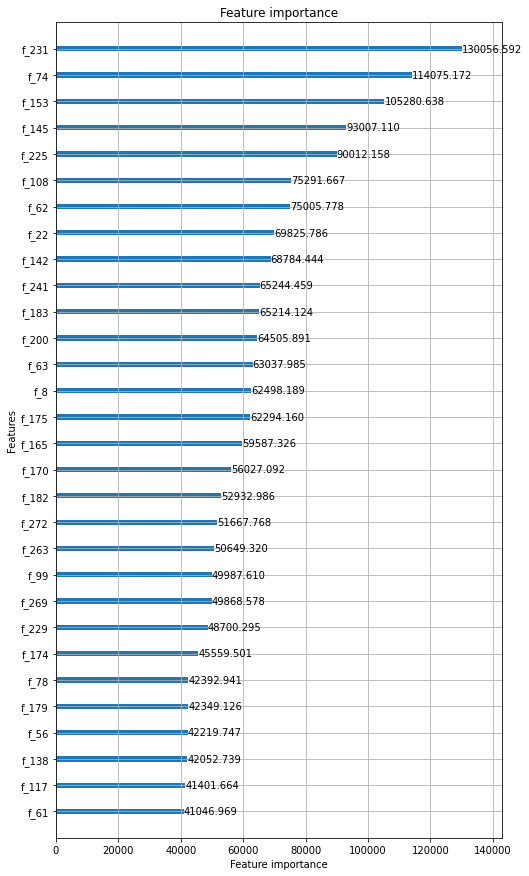

[50]	training's rmse: 0.908759	training's pearsonr: 0.176066


[100]	training's rmse: 0.904709	training's pearsonr: 0.202596


[150]	training's rmse: 0.902497	training's pearsonr: 0.218551


[200]	training's rmse: 0.900681	training's pearsonr: 0.230288


[250]	training's rmse: 0.899153	training's pearsonr: 0.240666


[300]	training's rmse: 0.898235	training's pearsonr: 0.247567


[350]	training's rmse: 0.89694	training's pearsonr: 0.253344


[400]	training's rmse: 0.89588	training's pearsonr: 0.259922


[450]	training's rmse: 0.894842	training's pearsonr: 0.266856


[500]	training's rmse: 0.893752	training's pearsonr: 0.272351


[550]	training's rmse: 0.893808	training's pearsonr: 0.27513


[600]	training's rmse: 0.893008	training's pearsonr: 0.277985


[650]	training's rmse: 0.892023	training's pearsonr: 0.282237


[700]	training's rmse: 0.891087	training's pearsonr: 0.286557


[750]	training's rmse: 0.890826	training's pearsonr: 0.289557


[800]	training's rmse: 0.89011	training's pearsonr: 0.292542


[850]	training's rmse: 0.888915	training's pearsonr: 0.297306


[900]	training's rmse: 0.888209	training's pearsonr: 0.300959


[950]	training's rmse: 0.88746	training's pearsonr: 0.304722


[1000]	training's rmse: 0.886765	training's pearsonr: 0.307889


[1050]	training's rmse: 0.886256	training's pearsonr: 0.310798


[1100]	training's rmse: 0.886044	training's pearsonr: 0.3129


[1150]	training's rmse: 0.88584	training's pearsonr: 0.314601


[1200]	training's rmse: 0.88528	training's pearsonr: 0.3164


[1250]	training's rmse: 0.884762	training's pearsonr: 0.318493


[1300]	training's rmse: 0.883995	training's pearsonr: 0.321377


[1350]	training's rmse: 0.883492	training's pearsonr: 0.324204


[1400]	training's rmse: 0.883687	training's pearsonr: 0.32525


[1450]	training's rmse: 0.882693	training's pearsonr: 0.328052


[1500]	training's rmse: 0.882659	training's pearsonr: 0.329394


[1550]	training's rmse: 0.882407	training's pearsonr: 0.33085


[1600]	training's rmse: 0.881335	training's pearsonr: 0.333882


[1650]	training's rmse: 0.880794	training's pearsonr: 0.336417


[1700]	training's rmse: 0.880266	training's pearsonr: 0.338701


[1750]	training's rmse: 0.879945	training's pearsonr: 0.340425


[1800]	training's rmse: 0.879686	training's pearsonr: 0.341772


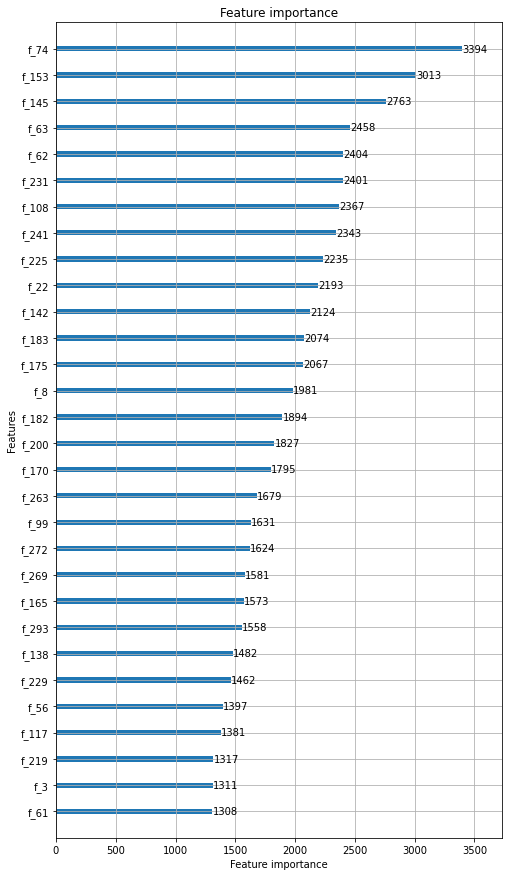

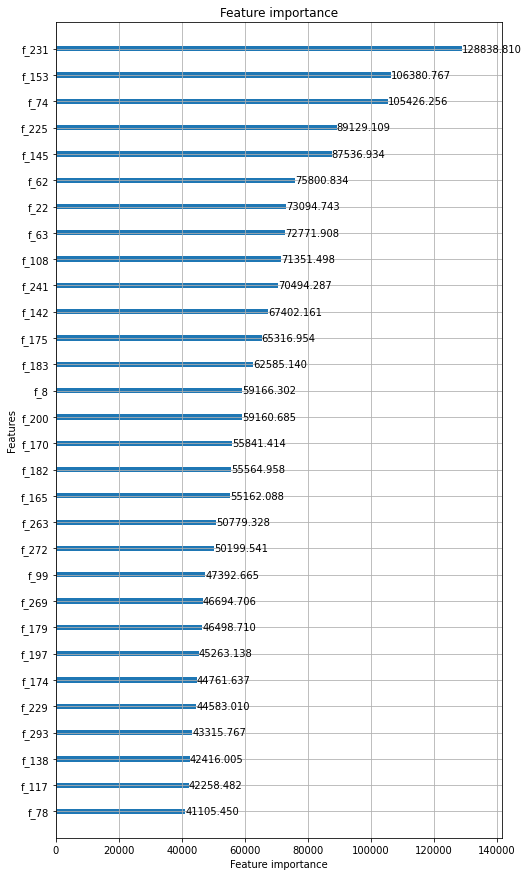

[50]	training's rmse: 0.908709	training's pearsonr: 0.174668


[100]	training's rmse: 0.904434	training's pearsonr: 0.202554


[150]	training's rmse: 0.902857	training's pearsonr: 0.217778


[200]	training's rmse: 0.901279	training's pearsonr: 0.22923


[250]	training's rmse: 0.899626	training's pearsonr: 0.238886


[300]	training's rmse: 0.898409	training's pearsonr: 0.246593


[350]	training's rmse: 0.897147	training's pearsonr: 0.25247


[400]	training's rmse: 0.896003	training's pearsonr: 0.259182


[450]	training's rmse: 0.894591	training's pearsonr: 0.266362


[500]	training's rmse: 0.893739	training's pearsonr: 0.271641


[550]	training's rmse: 0.893187	training's pearsonr: 0.275574


[600]	training's rmse: 0.892421	training's pearsonr: 0.280108


[650]	training's rmse: 0.891796	training's pearsonr: 0.283658


[700]	training's rmse: 0.891486	training's pearsonr: 0.28566


[750]	training's rmse: 0.890919	training's pearsonr: 0.288491


[800]	training's rmse: 0.890337	training's pearsonr: 0.291664


[850]	training's rmse: 0.890093	training's pearsonr: 0.293355


[900]	training's rmse: 0.88961	training's pearsonr: 0.295877


[950]	training's rmse: 0.888854	training's pearsonr: 0.298864


[1000]	training's rmse: 0.888328	training's pearsonr: 0.301702


[1050]	training's rmse: 0.887629	training's pearsonr: 0.304993


[1100]	training's rmse: 0.887098	training's pearsonr: 0.307179


[1150]	training's rmse: 0.886577	training's pearsonr: 0.310137


[1200]	training's rmse: 0.886097	training's pearsonr: 0.312371


[1250]	training's rmse: 0.885306	training's pearsonr: 0.315533


[1300]	training's rmse: 0.885126	training's pearsonr: 0.317352


[1350]	training's rmse: 0.88481	training's pearsonr: 0.319256


[1400]	training's rmse: 0.884127	training's pearsonr: 0.321251


[1450]	training's rmse: 0.884003	training's pearsonr: 0.322705


[1500]	training's rmse: 0.883191	training's pearsonr: 0.325384


[1550]	training's rmse: 0.882366	training's pearsonr: 0.328499


[1600]	training's rmse: 0.881855	training's pearsonr: 0.331057


[1650]	training's rmse: 0.881245	training's pearsonr: 0.333454


[1700]	training's rmse: 0.880418	training's pearsonr: 0.33663


[1750]	training's rmse: 0.880047	training's pearsonr: 0.338789


[1800]	training's rmse: 0.879702	training's pearsonr: 0.340607


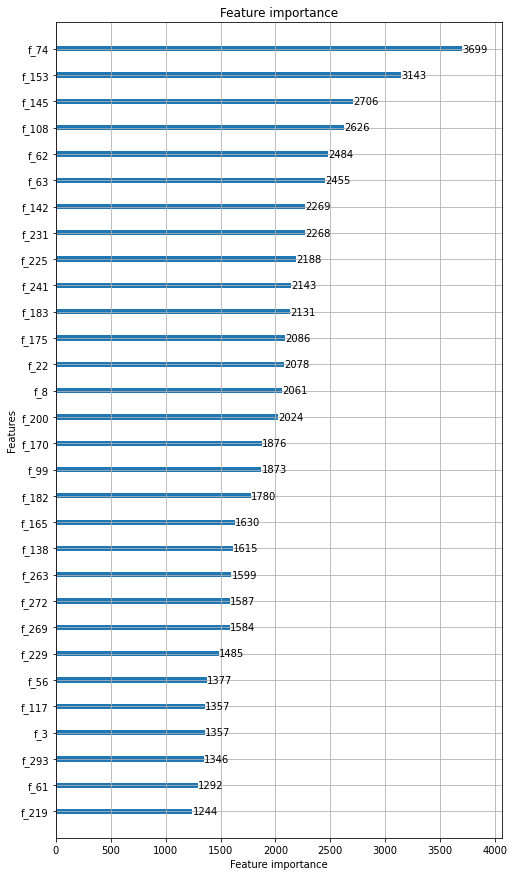

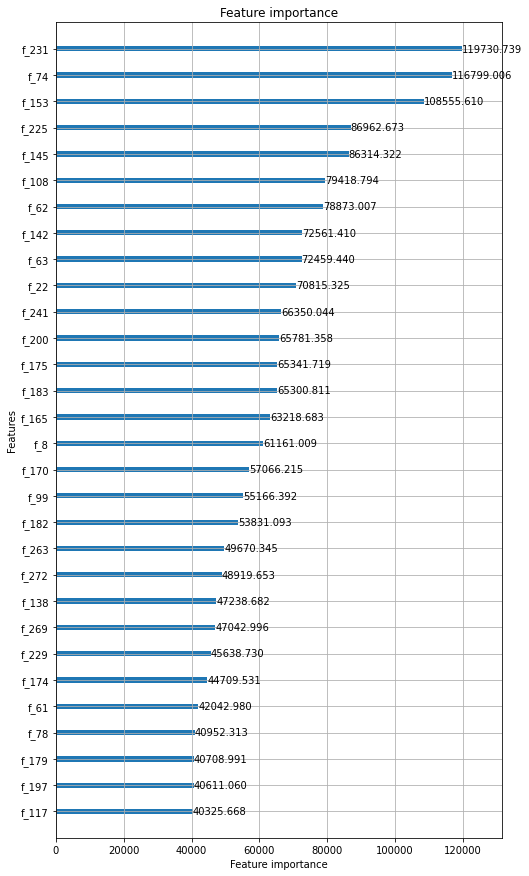

[50]	training's rmse: 0.909522	training's pearsonr: 0.171935


[100]	training's rmse: 0.90594	training's pearsonr: 0.195169


[150]	training's rmse: 0.903858	training's pearsonr: 0.211548


[200]	training's rmse: 0.90155	training's pearsonr: 0.225279


[250]	training's rmse: 0.89951	training's pearsonr: 0.237423


[300]	training's rmse: 0.897817	training's pearsonr: 0.246658


[350]	training's rmse: 0.896848	training's pearsonr: 0.254766


[400]	training's rmse: 0.89599	training's pearsonr: 0.259874


[450]	training's rmse: 0.89464	training's pearsonr: 0.266246


[500]	training's rmse: 0.893809	training's pearsonr: 0.271378


[550]	training's rmse: 0.893063	training's pearsonr: 0.275673


[600]	training's rmse: 0.892416	training's pearsonr: 0.279284


[650]	training's rmse: 0.892284	training's pearsonr: 0.281717


[700]	training's rmse: 0.891187	training's pearsonr: 0.286377


[750]	training's rmse: 0.89047	training's pearsonr: 0.289885


[800]	training's rmse: 0.889834	training's pearsonr: 0.293338


[850]	training's rmse: 0.889275	training's pearsonr: 0.295983


[900]	training's rmse: 0.888578	training's pearsonr: 0.299256


[950]	training's rmse: 0.888297	training's pearsonr: 0.301508


[1000]	training's rmse: 0.888424	training's pearsonr: 0.302705


[1050]	training's rmse: 0.888061	training's pearsonr: 0.304282


[1100]	training's rmse: 0.886997	training's pearsonr: 0.307329


[1150]	training's rmse: 0.886623	training's pearsonr: 0.30989


[1200]	training's rmse: 0.88628	training's pearsonr: 0.311992


[1250]	training's rmse: 0.885706	training's pearsonr: 0.314259


[1300]	training's rmse: 0.884861	training's pearsonr: 0.317235


[1350]	training's rmse: 0.883857	training's pearsonr: 0.320973


[1400]	training's rmse: 0.882965	training's pearsonr: 0.324652


[1450]	training's rmse: 0.882807	training's pearsonr: 0.326876


[1500]	training's rmse: 0.881731	training's pearsonr: 0.330373


[1550]	training's rmse: 0.881406	training's pearsonr: 0.332991


[1600]	training's rmse: 0.881001	training's pearsonr: 0.334994


[1650]	training's rmse: 0.880837	training's pearsonr: 0.336118


[1700]	training's rmse: 0.880227	training's pearsonr: 0.338281


[1750]	training's rmse: 0.880045	training's pearsonr: 0.339832


[1800]	training's rmse: 0.87938	training's pearsonr: 0.342128


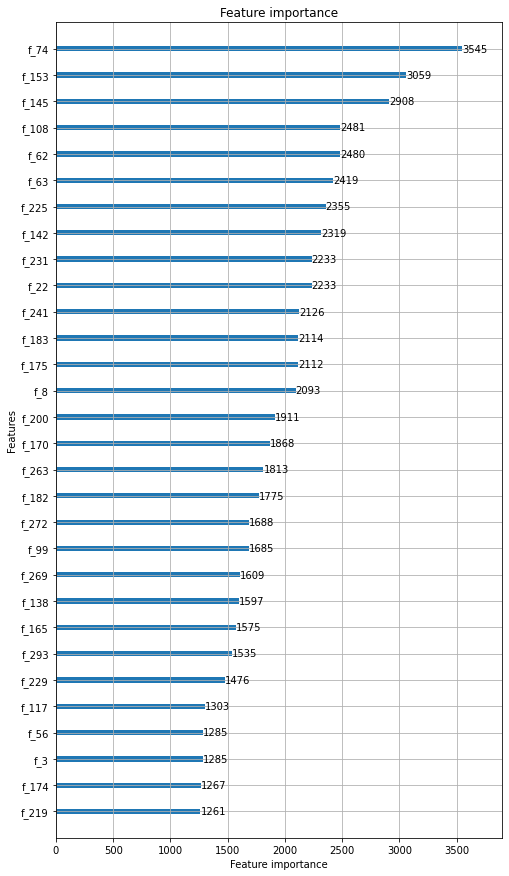

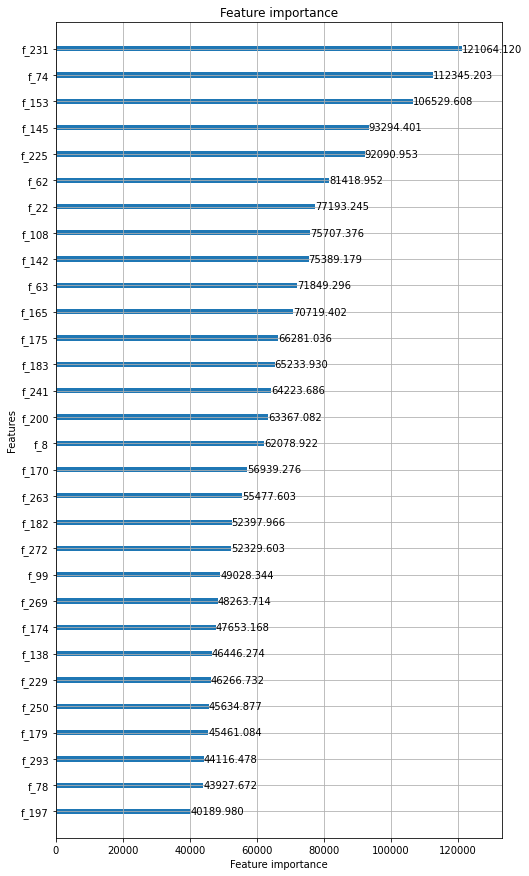

[50]	training's rmse: 0.909507	training's pearsonr: 0.171161


[100]	training's rmse: 0.905707	training's pearsonr: 0.197945


[150]	training's rmse: 0.903438	training's pearsonr: 0.212515


[200]	training's rmse: 0.901037	training's pearsonr: 0.227415


[250]	training's rmse: 0.899426	training's pearsonr: 0.237672


[300]	training's rmse: 0.897613	training's pearsonr: 0.247794


[350]	training's rmse: 0.897054	training's pearsonr: 0.253031


[400]	training's rmse: 0.89579	training's pearsonr: 0.259733


[450]	training's rmse: 0.894988	training's pearsonr: 0.265238


[500]	training's rmse: 0.893758	training's pearsonr: 0.271736


[550]	training's rmse: 0.893415	training's pearsonr: 0.274911


[600]	training's rmse: 0.892584	training's pearsonr: 0.27924


[650]	training's rmse: 0.892265	training's pearsonr: 0.281832


[700]	training's rmse: 0.891547	training's pearsonr: 0.285569


[750]	training's rmse: 0.890545	training's pearsonr: 0.289322


[800]	training's rmse: 0.890123	training's pearsonr: 0.292552


[850]	training's rmse: 0.889448	training's pearsonr: 0.295309


[900]	training's rmse: 0.888835	training's pearsonr: 0.298607


[950]	training's rmse: 0.888876	training's pearsonr: 0.299734


[1000]	training's rmse: 0.887932	training's pearsonr: 0.303015


[1050]	training's rmse: 0.887567	training's pearsonr: 0.305193


[1100]	training's rmse: 0.886972	training's pearsonr: 0.308416


[1150]	training's rmse: 0.886386	training's pearsonr: 0.310892


[1200]	training's rmse: 0.886179	training's pearsonr: 0.312715


[1250]	training's rmse: 0.885926	training's pearsonr: 0.314761


[1300]	training's rmse: 0.885625	training's pearsonr: 0.316081


[1350]	training's rmse: 0.885439	training's pearsonr: 0.317318


[1400]	training's rmse: 0.885226	training's pearsonr: 0.3185


[1450]	training's rmse: 0.885	training's pearsonr: 0.320032


[1500]	training's rmse: 0.884936	training's pearsonr: 0.320606


[1550]	training's rmse: 0.884419	training's pearsonr: 0.322372


[1600]	training's rmse: 0.884092	training's pearsonr: 0.323916


[1650]	training's rmse: 0.883805	training's pearsonr: 0.325186


[1700]	training's rmse: 0.883164	training's pearsonr: 0.327005


[1750]	training's rmse: 0.882441	training's pearsonr: 0.32976


[1800]	training's rmse: 0.881954	training's pearsonr: 0.331712


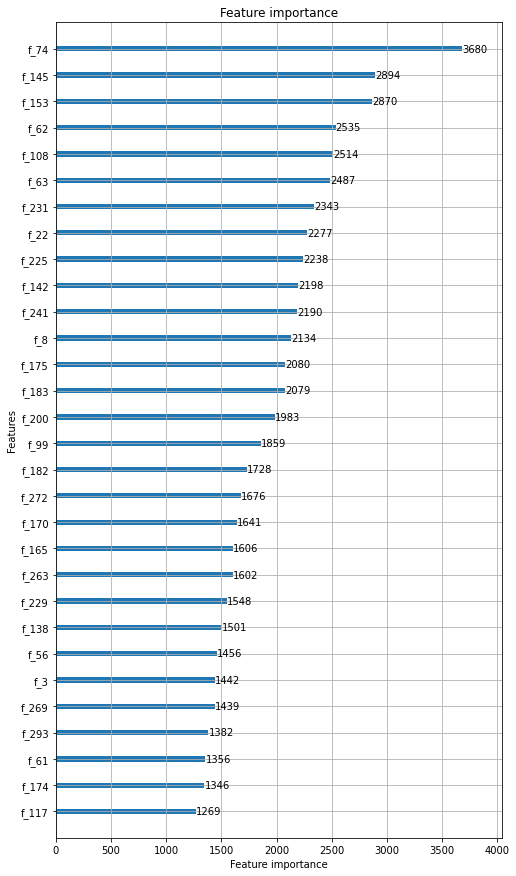

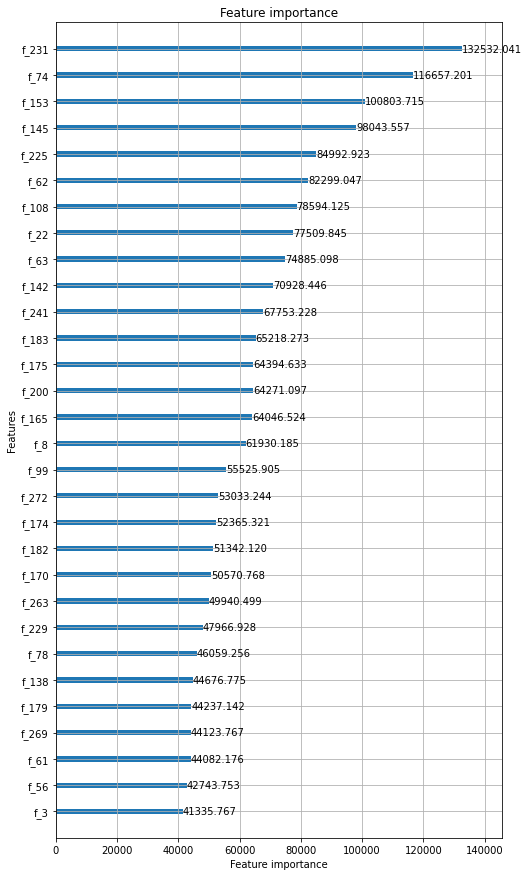

In [14]:
seeds = [
    2, 3, 5, 7, 11, 
    #13, 17, 19, 23, 29, 
    #31, 37, 41, 43, 47, 
    #53, 59, 61, 67, 71, 
    #73, 79, 83, 89, 97,
]
models = list()

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    _model_params["drop_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[lgb.log_evaluation(period=50)],
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-dart/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***